In [58]:
import pandas as pd
from utils import *
import time
import numpy as np
import math
import matplotlib.pyplot as plt
# Torch package
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [59]:
tf.random.set_seed(15)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Read Data

In [60]:
df = pd.read_csv('Processed_data.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Initial dataframe has few rows which has zeros for features like "SMA_7" etc and hence removing few top rows
df=df[50:]
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [61]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_H-L', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
29


## Normalize data

In [62]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [63]:
df.head()

,Close,Volume,EMA_7,EMA_14,EMA_21,SMA_7,SMA_14,SMA_21,MACD_12_26_9,MACDh_12_26_9,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
50,-2.216035,0.076483,-2.142262,-2.152261,-2.194267,-2.125236,-2.076858,-2.136731,0.580627,-0.832570,...,-0.051602,1.239983,0.263215,0.069296,-0.504898,-0.245371,0.621244,0.493902,0.076677,-2.216035
51,-2.056965,-0.239245,-2.123602,-2.142163,-2.184183,-2.111332,-2.077166,-2.125910,0.587184,-0.650028,...,-0.049936,0.645604,-1.592823,0.546749,0.078090,-0.237026,-0.837124,-0.175958,0.061469,-2.056965
52,-2.098709,-0.344334,-2.120115,-2.139050,-2.178879,-2.117365,-2.077906,-2.121902,0.551176,-0.605426,...,-0.049715,0.155241,0.435721,0.581028,6.329870,-1.246710,0.090208,-0.326489,0.989154,-2.098709
53,-2.101239,0.232217,-2.118136,-2.136693,-2.174291,-2.119588,-2.081983,-2.115752,0.513769,-0.573078,...,-0.049288,0.938548,0.039596,0.103050,0.078090,0.572390,-0.203051,-1.432887,0.008242,-2.101239
54,-2.114521,0.606201,-2.119995,-2.136444,-2.171350,-2.119997,-2.105306,-2.108239,0.467045,-0.569404,...,-0.048312,0.724147,0.148211,-0.139122,1.708155,0.405500,0.288356,0.019731,0.152717,-2.114521


## Data processing for time series model

The data processing is to prepare the data in a sequence of past observations. Preparation of the time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance and window decides how many days we want to predict for. If the sequence length is $n$ and window is $w$, then the LSTM considers the last $n$ observations to predict the next $w$ day price.

In [64]:
sequence_length = 60
window =10

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,2):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return torch.FloatTensor(np.array(X_store)), torch.FloatTensor(np.array(y_store))

In [65]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df)*0.96)
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 3208
Train sample 3079
Test sample 129


In [66]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

X_train=torch.FloatTensor(np.array(X_train))
y_train=torch.FloatTensor(np.array(y_train))

print(X_train.shape, y_train.shape)

torch.Size([1505, 60, 29]) torch.Size([1505, 10])


In [67]:
# Test data
X_test, y_test = create_dataset(
    df_test,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

X_test=torch.FloatTensor(np.array(X_test))
y_test=torch.FloatTensor(np.array(y_test))

print(X_test.shape, y_test.shape)

torch.Size([30, 60, 29]) torch.Size([30, 10])


In [68]:
batch_size=10
train_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
test_loader= DataLoader(data.TensorDataset(X_test, y_test), shuffle=True, batch_size=batch_size)

In [69]:
# The unknown data
X_check=(df_train[features].values)[len(df_train)-sequence_length:len(df_train)]
y_check=(df_test[target].values)[:window]
torch.FloatTensor([X_check]).shape

torch.Size([1, 60, 29])

## Classical LSTM

We first define train_model: function to train the model based on the batches of data
We print the loss at the end to understand how the model is performing with regards to the data.

In [70]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

## Classical LSTM

In [71]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1) # The output dimesion is set as window
        self.linear_2 = nn.Linear(in_features=60, out_features=10)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        out_l1, (hn, _) = self.lstm(x, (h0, c0))
        out_l2 = self.linear(out_l1)
        out = self.linear_2(torch.squeeze(out_l2))
        return torch.squeeze(out)

In [72]:
learning_rate = 0.001
num_hidden_units = 16

model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [73]:
lstm_loss_train = []
lstm_loss_test=[]
num_epoch=12
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model_lstm, loss_function)
    lstm_loss_train.append(train_loss)
    lstm_loss_test.append(test_loss)

Epoch 0
---------
Train loss: 0.3578976307631723
Test loss: 0.023320284361640613
Epoch 1
---------
Train loss: 0.0964452400556858
Test loss: 0.020240865647792816
Epoch 2
---------
Train loss: 0.06925558752768876
Test loss: 0.01897266134619713
Epoch 3
---------
Train loss: 0.05903856806605067
Test loss: 0.01843634309868018
Epoch 4
---------
Train loss: 0.05094065175496584
Test loss: 0.026794563978910446
Epoch 5
---------
Train loss: 0.04546163956455837
Test loss: 0.06199351573983828
Epoch 6
---------
Train loss: 0.04427043376305443
Test loss: 0.030182429899772007
Epoch 7
---------
Train loss: 0.03866795722444523
Test loss: 0.04428071901202202
Epoch 8
---------
Train loss: 0.03684275446842048
Test loss: 0.02470926692088445
Epoch 9
---------
Train loss: 0.03439883298752521
Test loss: 0.026324304441610973
Epoch 10
---------
Train loss: 0.032820831583381095
Test loss: 0.027206328387061756
Epoch 11
---------
Train loss: 0.031207971028144786
Test loss: 0.02344446008404096


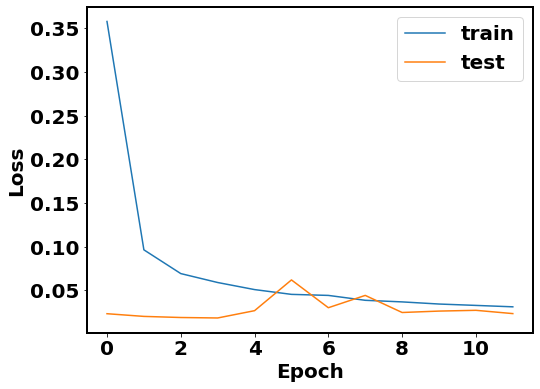

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epoch), lstm_loss_train, label='train')
plt.plot(range(num_epoch), lstm_loss_test, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [75]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output.append(y_star.numpy())  
    return output

In [76]:
# Prepare data to evaluate training accuracy of lstm
train_eval_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=batch_size)
y_train_pred_lstm=predict(train_eval_loader, model_lstm)
y_train_lstm=[]
for X, y in train_eval_loader:
    y_train_lstm.append(y)
    
# Prepare data to evaluate test accuracy of lstm
test_eval_loader = DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=batch_size)
y_test_pred_lstm=predict(test_eval_loader, model_lstm)
y_test_lstm=[]
for X, y in test_eval_loader:
    y_test_lstm.append(y)

In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [78]:
mae_train_lstm, rmse_train_lstm= cal_metrics(y_train_lstm,y_train_pred_lstm)
print('MAE train error is',mae_train_lstm)
print('RMSE train error is',rmse_train_lstm)

mae_test_lstm, rmse_test_lstm= cal_metrics(y_test_lstm,y_test_pred_lstm)
print('MAE test error is',mae_test_lstm)
print('RMSE test error is',rmse_test_lstm)

MAE train error is 83.40465421866108
RMSE train error is 106.97026905792438
MAE test error is 79.15838114420573
RMSE test error is 95.78101857503255


In [79]:
y_check_pred_lstm = model_lstm(torch.FloatTensor([X_check]))
y_check_pred_lstm = y_check_pred_lstm.detach().numpy()

mae_check_lstm = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean)
print('MAE check error  : ',mae_check_lstm)
rmse_check_lstm = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean, squared=False)
print('RMSE check error : ',rmse_check_lstm)

MAE check error  :  93.22048046874997
RMSE check error :  99.54305347355756


In [80]:
for k in range(len(X_test)):
    y_k = model_lstm(torch.FloatTensor([X_test[k].numpy()]))
    y_k=y_k.detach().numpy()
    x1_k=y_k*target_stdev + target_mean
    x2_k=y_test[k]*target_stdev + target_mean
    print('MAE Error',mean_absolute_error(x1_k, x2_k ) )

MAE Error 115.747604
MAE Error 69.14126
MAE Error 71.907326
MAE Error 80.10435
MAE Error 70.08413
MAE Error 59.75376
MAE Error 62.339745
MAE Error 39.166748
MAE Error 18.72041
MAE Error 34.72827
MAE Error 51.058006
MAE Error 50.438232
MAE Error 49.11382
MAE Error 59.125195
MAE Error 81.34737
MAE Error 101.77158
MAE Error 104.67822
MAE Error 82.968605
MAE Error 96.19448
MAE Error 126.45557
MAE Error 128.54443
MAE Error 129.469
MAE Error 100.66709
MAE Error 47.291893
MAE Error 43.46636
MAE Error 56.850586
MAE Error 59.572998
MAE Error 85.25352
MAE Error 139.14908
MAE Error 159.6416


## Running the ARIMA 

In [81]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

<ipython-input-81-82fdbb8aee4b>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
<ipython-input-81-82fdbb8aee4b>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [82]:
train_data_arima=df_train[target].values # train on full data
check_data_arima=df_test[target].values[:window]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5498.728, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5496.823, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5496.824, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5500.393, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5495.682, Time=0.80 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.769 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3079
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2751.197
Date:                Fri, 08 Mar 2024   AIC                          -5500.393
Time:                        08:50:20   BIC                          -5494.361
Sample:                             0   HQIC                         -5498.227
                               - 3079                                  

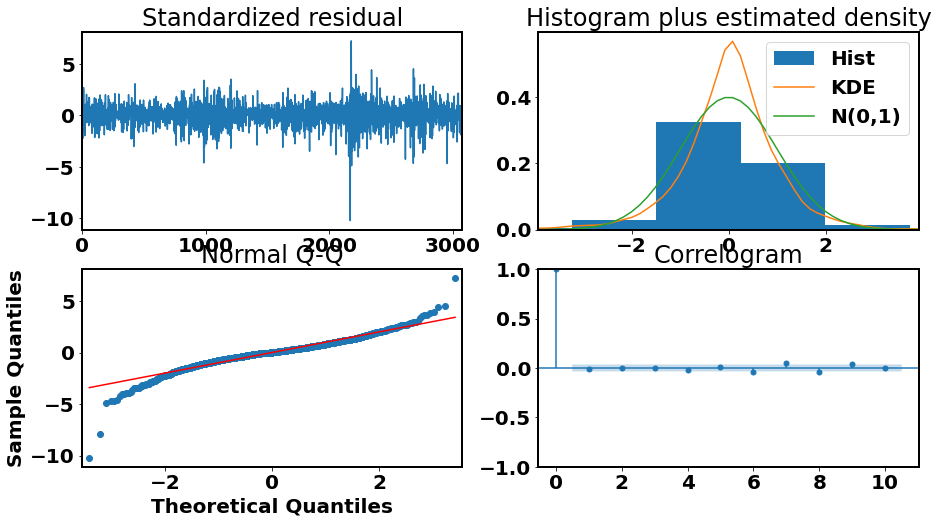

In [83]:
model_autoARIMA = auto_arima(train_data_arima, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [84]:
import statsmodels.api as sm
model_arima = ARIMA(train_data_arima, order=(0,1,0))  
fitted = model_arima.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3079
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2751.197
Date:                Fri, 08 Mar 2024   AIC                          -5500.393
Time:                        08:50:20   BIC                          -5494.361
Sample:                             0   HQIC                         -5498.227
                               - 3079                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0098      0.000     85.710      0.000       0.010       0.010
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              7626.38
Prob(Q):                              0.76   Pr

In [85]:
# Forecast
y_check_pred_arima = fitted.forecast(window, alpha=0.05)  # 95% conf

C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [86]:
mae_check_arima = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_arima* target_stdev + target_mean)
print('Mean absolute error(check) : ',mae_check_arima)
rmse_check_arima = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_arima* target_stdev + target_mean, squared=False)
print('Root Mean Squared error(check) : ',rmse_check_arima)

Mean absolute error(check) :  94.9149999999997
Root Mean Squared error(check) :  130.41979792194104


## Data processing for regression model

In [87]:
df_all=df.copy()

tf.random.set_seed(15)
target_sensor = "Close"
forecast_lead = 10 # Sequence length
target_reg = f"{target_sensor}_lead{forecast_lead}"

df_all[target_reg ] = df_all[target_sensor].shift(-forecast_lead)
df_all= df_all.iloc[:-forecast_lead]

In [88]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df_all)*0.96)
df_train_reg=df_all[:size]
df_test_reg=df_all[size:]
print('Total sample', len(df_all))
print('Train sample', len(df_train_reg))
print('Test sample', len(df_test_reg))

Total sample 3198
Train sample 3070
Test sample 128


In [89]:
df_train_reg.columns

Index(['Close', 'Volume', 'EMA_7', 'EMA_14', 'EMA_21', 'SMA_7', 'SMA_14',
       'SMA_21', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0',
       'GBP USD ', 'Gold in USD close', 'Crude Futures_close',
       'Crude Futures_volume', '3M', 'FTSE_H-L', 'FTSE_O-C', 'GBP_USD_H-L',
       'GBP_USD_O-C', 'Gold_H-L', 'Gold_O-C', 'Crude_H-L', 'Crude_O-C',
       'Close_copy', 'Close_lead10'],
      dtype='object')

In [90]:
print(target_reg)
features_reg = list(df_all.columns.difference([target_sensor,target_reg]))
print( len(features_reg) )

Close_lead10
29


In [91]:
X_train_reg_=df_train_reg[features_reg]
print(X_train_reg_.shape)
y_train_reg_=df_train_reg[target_reg]
print(y_train_reg_.shape)

(3070, 29)
(3070,)


In [92]:
X_test_reg_=df_test_reg[features_reg]
print(X_test_reg_.shape)
y_test_reg_=df_test_reg[target_reg]
print(y_test_reg_.shape)

(128, 29)
(128,)


## Linear regression model

In [93]:
from sklearn.linear_model import LinearRegression
#Creating the Regressor
regressor = LinearRegression()
regressor.fit(X_train_reg_, y_train_reg_)

LinearRegression()

In [94]:
y_train_pred_mlr=regressor.predict(X_train_reg_)
mae_train_mlr = mean_absolute_error(y_train_reg_* target_stdev + target_mean,y_train_pred_mlr* target_stdev + target_mean)
print('MAE train Error : ',mae_train_mlr)
rmse_train_mlr = mean_squared_error(y_train_reg_* target_stdev + target_mean,y_train_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE train Error : ',rmse_train_mlr)

MAE train Error :  133.94559540357977
RMSE train Error :  186.69294010825192


In [95]:
y_test_pred_mlr=regressor.predict(X_test_reg_)
mae_test_mlr = mean_absolute_error(y_test_reg_* target_stdev + target_mean,y_test_pred_mlr* target_stdev + target_mean)
print('MAE test Error : ',mae_test_mlr)
rmse_test_mlr = mean_squared_error(y_test_reg_* target_stdev + target_mean,y_test_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE test Error : ',rmse_test_mlr)

MAE test Error :  121.88523755171843
RMSE test Error :  145.01093864353663


## XGboost

In [96]:
import xgboost as xg

In [97]:
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                   seed = 123) 
# Fitting the model 
xgb_r.fit(X_train_reg_, y_train_reg_) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [98]:
# Predict the model 
y_train_pred_xg = xgb_r.predict(X_train_reg_) 
mae_train_xg = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_xg* target_stdev + target_mean)
print('MAE train: ',mae_train_xg)
rmse_train_xg = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_xg* target_stdev + target_mean, squared=False)
print('RMSE train: ',rmse_train_xg)

MAE train:  10.95209868052728
RMSE train:  14.957343780914519


In [99]:
# Predict the model 
y_test_pred_xg = xgb_r.predict(X_test_reg_) 
mae_test_xg = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_xg* target_stdev + target_mean)
print('MAE test: ',mae_test_xg)
rmse_test_xg = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_xg* target_stdev + target_mean, squared=False)
print('RMSE test: ',rmse_test_xg)

MAE test:  130.23293457031247
RMSE test:  157.36241618278117


## ANN

In [100]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model
from keras.layers.advanced_activations import PReLU

In [101]:
input_ = Input((len(features),)) # feature

den1=Dense(128, use_bias=True,activation=PReLU())(input_)

den2=Dense(64, use_bias=True,activation=PReLU())(den1)

den3=Dense(32, use_bias=True,activation=PReLU())(den2)

den4=Dense(8, use_bias=True,activation=PReLU())(den3)

den5=Dense(1, use_bias=True,activation='linear')(den4)

model_ann = Model(inputs=[input_], outputs=den5)

In [102]:
import tensorflow as tf

In [103]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_ann.compile(opt, loss=loss_fn)

In [104]:
model_history = model_ann.fit(X_train_reg_, y_train_reg_,
                    validation_data=(X_test_reg_, y_test_reg_),
                   batch_size=10, 
                   epochs=200,  # total epoch
                   )

Epoch 1/200
307/307 [==============================] - 1s 2ms/step - loss: 0.1269 - val_loss: 0.0397
Epoch 2/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0804 - val_loss: 0.0366
Epoch 3/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0897 - val_loss: 0.0405
Epoch 4/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0653
Epoch 5/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0431
Epoch 6/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0545 - val_loss: 0.0455
Epoch 7/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.0533
Epoch 8/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0502 - val_loss: 0.1006
Epoch 9/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0489 - val_loss: 0.0541
Epoch 10/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0452 - val_lo

307/307 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0494
Epoch 82/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0531
Epoch 83/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0725
Epoch 84/200
307/307 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0651
Epoch 85/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0648
Epoch 86/200
307/307 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0533
Epoch 87/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0689
Epoch 88/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0510
Epoch 89/200
307/307 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0475
Epoch 90/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 

Epoch 161/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0488
Epoch 162/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0545
Epoch 163/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0531
Epoch 164/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0505
Epoch 165/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0472
Epoch 166/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0540
Epoch 167/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0428
Epoch 168/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0481
Epoch 169/200
307/307 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0554
Epoch 170/200
307/307 [==============================] - 0s 1ms/step - lo

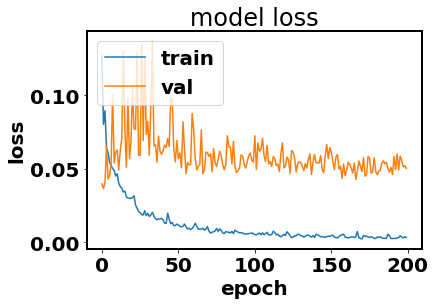

In [105]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [106]:
# Predict the model 
y_train_pred_ann = model_ann.predict(X_train_reg_) 
mae_train_ann = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean)
print('MAE train: ',mae_train_ann)
rmse_train_ann = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE train: ',rmse_train_ann)

MAE train:  27.647439313161637
RMSE train:  37.38956373245263


In [107]:
# Predict the model 
y_test_pred_ann = model_ann.predict(X_test_reg_) 
mae_test_ann = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean)
print('MAE test: ',mae_test_ann)
rmse_test_ann = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE test : ',rmse_test_ann)

MAE test:  116.37229431152343
RMSE test :  141.78880394239604


In [108]:
model_ann.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_5 (Dense)             (None, 128)               3968      
                                                                 
 dense_6 (Dense)             (None, 64)                8320      
                                                                 
 dense_7 (Dense)             (None, 32)                2112      
                                                                 
 dense_8 (Dense)             (None, 8)                 272       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 14,681
Trainable params: 14,681
Non-trainable

# Output

In [109]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_train_lstm,mae_test_lstm, rmse_train_lstm,rmse_test_lstm], 
    ["Multiple linear regression",mae_train_mlr,mae_test_mlr, rmse_train_mlr,rmse_test_mlr], 
      ["XGboost", mae_train_xg, mae_test_xg, rmse_train_xg,rmse_test_xg],
    ["ANN", mae_train_ann, mae_test_ann,  rmse_train_ann ,rmse_test_ann]
]
 
# create header
head = ["Model","Train MAE" ,"Test MAE", "Train RMSE","Test RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+-------------+------------+--------------+-------------+
| Model                      |   Train MAE |   Test MAE |   Train RMSE |   Test RMSE |
+============================+=============+============+==============+=============+
| LSTM                       |     83.4047 |    79.1584 |     106.97   |      95.781 |
+----------------------------+-------------+------------+--------------+-------------+
| Multiple linear regression |    133.946  |   121.885  |     186.693  |     145.011 |
+----------------------------+-------------+------------+--------------+-------------+
| XGboost                    |     10.9521 |   130.233  |      14.9573 |     157.362 |
+----------------------------+-------------+------------+--------------+-------------+
| ANN                        |     27.6474 |   116.372  |      37.3896 |     141.789 |
+----------------------------+-------------+------------+--------------+-------------+


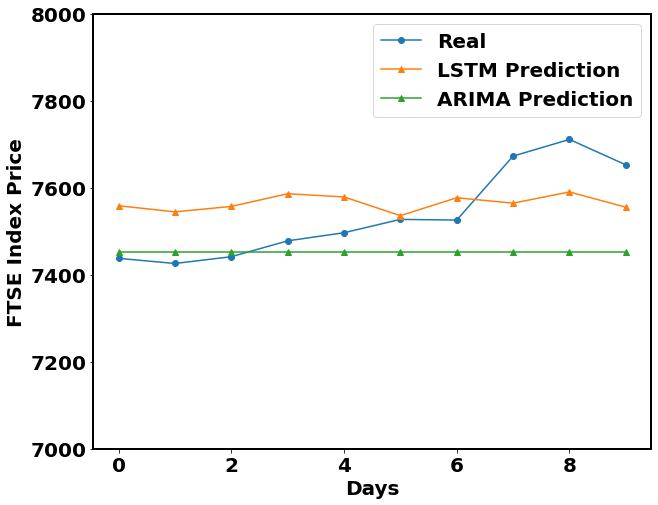

In [110]:
plt.figure(figsize=(10, 8))
plt.plot(y_check* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_pred_lstm* target_stdev + target_mean, label = "LSTM Prediction",marker='^')
plt.plot(y_check_pred_arima* target_stdev + target_mean, label = "ARIMA Prediction",marker='^')
plt.ylabel('FTSE Index Price')
plt.xlabel('Days')
plt.ylim(7000, 8000) 
plt.legend()
plt.show()

In [111]:
total_params = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)

print("No. of parameters for Classical LSTM: ", total_params)

No. of parameters for Classical LSTM:  5811
